## Dcc Vector: Average of Word Vectors

Continued from Part 2 Bag of Words

Bag-of-Words is the most straightforward way of vectorization. In this part, we'll try the Word2Vec algorithm:
We'll find the embedding of word in each review document, and the document will be represented as the average of the word vectors.

In [1]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Load processed data

In [2]:
train = pd.read_csv("labeledTrainData.tsv",
                    delimiter="\t",
                    header=0,
                    quoting=3)

unlabeled = pd.read_csv("unlabeledTrainData.tsv",
                        delimiter="\t",
                        header=0,
                        quoting=3)

train_sents = pickle.load(open("train_sents.pickle"))
unlabeled_sents = pickle.load(open("unlabeled_sents.pickle"))

In [3]:
train[:2]

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."


In [4]:
unlabeled[:2]

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."


In [5]:
train_sents[-1:]

["I saw this movie as a child and it broke my heart ! No other story had such a unfinished ending ... I grew up on many great anime movies and this was one of my favourites , because it was so unusual - a story about unfairness , and cruelty , and loneliness , and life , and choices that ca n't be undone , and the need for others . Chirin is made alone when the Wolf kills his mother , but the Wolf is alone , too , when Chirin follows him into the mountain . The Wolf does n't kill the lamb , even though each night he says `` maybe I 'll eat you tomorrow . '' The tape of it I have is broken and degraded from age and use . I will repair it and watch the movie again someday and cry just as hard as I did as a child . Stories like this , with this depth and feeling , and this intricacy of meaning , are very rare . It is a sad story , but I 've never encountered any catharsis more beautifully made . I am glad I have seen this movie , and I 'm glad I saw it as a child ."]

In [6]:
unlabeled_sents[-1:]

["This not-very-good mummy-alien flick does feature a cornucopia of your favorite movie stars like BEN MURPHY `` Riding With Death '' ! , Bob Random `` Village of the Giants '' ! , Darwin Joston Napolean in `` Assault on Precinct NUM '' ! , Austin Stoker Bishop in `` Assault on Precinct NUM '' ! as Dr. Ken Melrose , Nina Axelrod `` Motel Hell '' , Shari Belafonte-Harper who was a voice on `` Rick Moranis in Gravedale High '' ! ! ! , Clint Young `` Rape Squad '' , `` Switchblade Sisters '' , and best of all , Pathmark pitchman JAMES KAREN `` Poltergiest '' , `` Return of the Living Dead '' ! The plot is this : A priceless sarcophagus has been recovered in King Tut 's tomb . Of course , it 's taken to a small college in California where bumbling students can manhandle it and screw up X-raying it , instead of , oh , say , a museum . One loathsome , video-game loving student steals some diamond-type-thingees from the sarcophagus , sending the mummy on a poorly planned killing spree to get 

Each review document will be first tokenized into sentences, and each sentence will be tokenized into words. The input to word2vec will be obtained by chaining sentences together (i.e. an iterable of list of words)

In [7]:
from gensim.models.word2vec import Word2Vec
import itertools
from nltk.tokenize import sent_tokenize

# from labeled reviews
train_sents_iter = map(lambda doc: map(lambda sent: sent.split(), sent_tokenize(doc)), train_sents)
train_sents_iter = list(itertools.chain(*train_sents_iter))

# from unlabeled reviews
unlabeled_sents_iter = map(lambda doc: map(lambda sent: sent.split(), sent_tokenize(doc)), unlabeled_sents)
unlabeled_sents_iter = list(itertools.chain(*unlabeled_sents_iter))

# combined 
sents = list(itertools.chain(train_sents_iter, unlabeled_sents_iter))

**sents** contains list of sentences (sentence represented as list of words)

In [8]:
print sents[:2]

[['With', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'MJ', 'i', "'ve", 'started', 'listening', 'to', 'his', 'music', ',', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', ',', 'watched', 'The', 'Wiz', 'and', 'watched', 'Moonwalker', 'again', '.'], ['Maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent', '.']]


In [9]:
len(sents)

957389

We'll try both the **CBOW** (sg=0) and **Skip-gram** (sg=1) architecture

In [10]:
num_features = 200
models = [Word2Vec(workers=4, sg=0, size=num_features, window=10, min_count=40, sample=1e-3, iter=10),
          Word2Vec(workers=4, sg=1, size=num_features, window=10, min_count=40, sample=1e-3, iter=10)]

names = ["Continuous BOW", "Skip-gram"]

The helper function that turn each review (a string, raw text) into the average of vectors of words (that are present in the word2vec model):

In [11]:
def word_vec_average(review, model):
    """
    review: str
    model: word2vec object
    """
    vec_average, count = np.zeros(num_features, dtype=np.float64), 0
    
    words = review.split()
    for word in words:
        if word in model:
            vec_average += model[word]
            count +=1
    vec_average /= count
    return vec_average

We'll project vector representation (average of word vectors) into 2-D and 1-D space using PCA and Linear Discriminant Analysis, so we can see how well the two classes are separated.

We'll use a simple linear model LogisticRegression to test out the quality of the vector representation in a binary classification task.

Note Word2Vec is unsupervised, so it can be trained using both labeled and unlabeled reviews.

Continuous BOW: Word2Vec(vocab=0, size=200, alpha=0.025)
accuracy = 0.867200



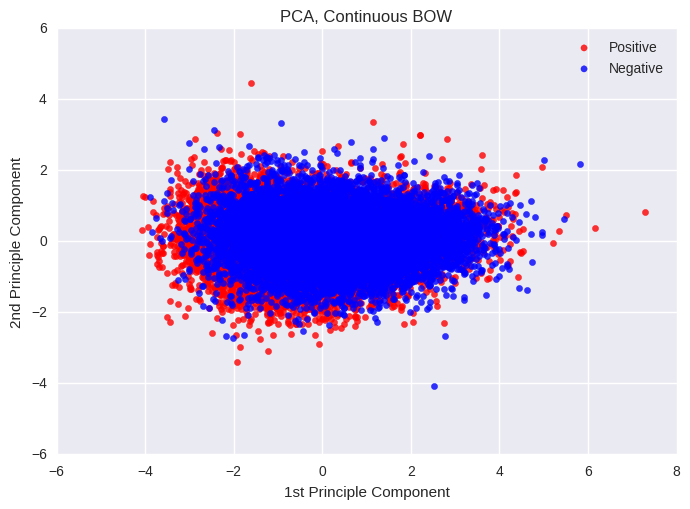

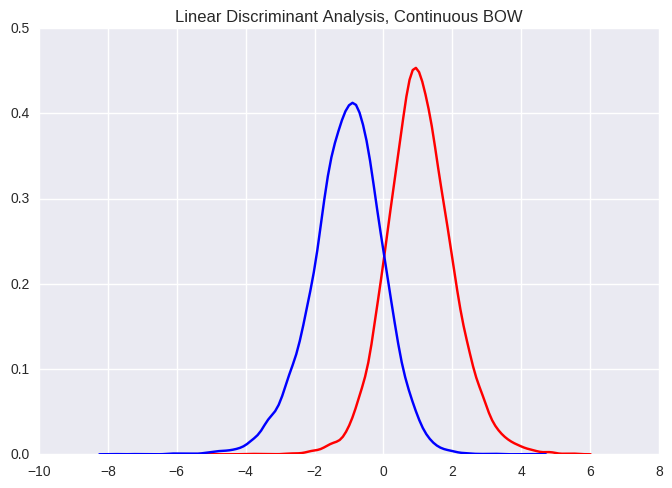

Skip-gram: Word2Vec(vocab=0, size=200, alpha=0.025)
accuracy = 0.869200



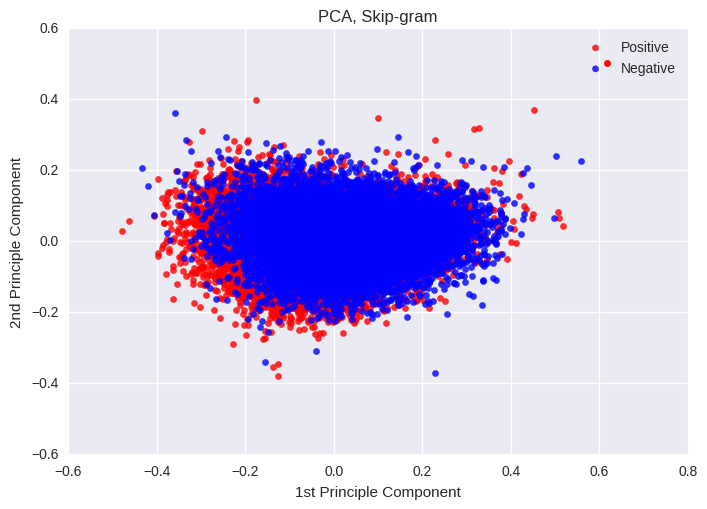

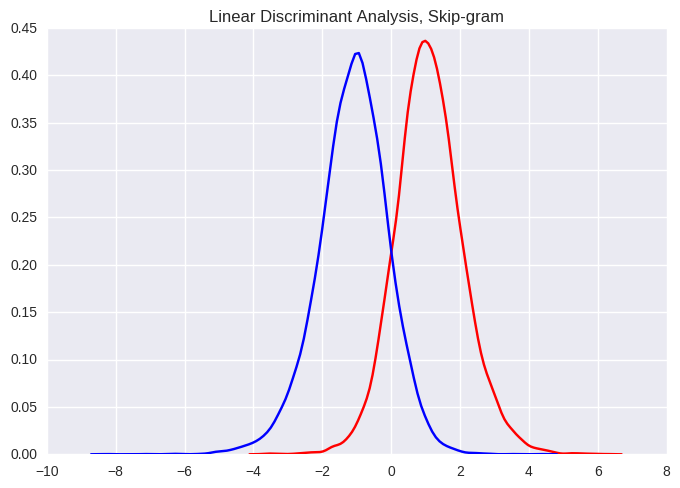

In [12]:
for model, name in zip(models, names):
    print "%s: %s" % (name, str(model))
    model.build_vocab(sents)
    model.train(sents)
    
    X = np.array([word_vec_average(review, model) for review in train_sents])
    
    y = train["sentiment"].values
    lr = LogisticRegression(random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print "accuracy = %f\n" % lr.fit(X_train, y_train).score(X_test, y_test)
    
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)
    labels = ["positive", "negative"]
    for color, i, label in zip(["red", "blue"], [1, 0], labels):
        plt.scatter(X_r[y==i, 0], X_r[y==i, 1], color=color, alpha=0.8, label=label)
    plt.xlabel("1st Principle Component")
    plt.ylabel("2nd Principle Component")
    plt.legend(["Positive", "Negative"])
    plt.title("PCA, " + name )
    plt.show()    
    
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r2 = lda.fit(X, y).transform(X).ravel()
    pos, neg = X_r2[y==1], X_r2[y==0]
    sns.kdeplot(pos, color="red")
    plt.hold(True)
    sns.kdeplot(neg, color="blue")
    plt.legend(["Positive", "Negative"])
    plt.title("Linear Discriminant Analysis, " + name)
    plt.show()    

Looks like CBOW and Skip-gram had comparable performance in the binary classification task.

Let's test some of the word vectors to see if they makes sense:

In [13]:
model.most_similar("computer")

[('computers', 0.6206517219543457),
 ('software', 0.5922451019287109),
 ('high-tech', 0.5363542437553406),
 ('laptop', 0.5300710797309875),
 ('monitor', 0.5231302976608276),
 ('graphics', 0.5197060704231262),
 ('tech', 0.5162307620048523),
 ('technology', 0.51297926902771),
 ('CGI', 0.511073112487793),
 ('hacker', 0.5035932064056396)]

In [14]:
model.most_similar("musician")

[('singer', 0.5666239857673645),
 ('pianist', 0.5159332156181335),
 ('artist', 0.4934384524822235),
 ('jazz', 0.48284780979156494),
 ('piano', 0.46873295307159424),
 ('concert', 0.45913374423980713),
 ('hip-hop', 0.45403873920440674),
 ('musicians', 0.45067211985588074),
 ('prodigy', 0.448078453540802),
 ('playwright', 0.44796645641326904)]

## Word clustering: Bag of Centroids

Now that we have vector representation of words, we can try to do a clustering on words, which maps words to cluster centroids. This way we can turn the bag-of-words representation to bag-of-centroids: group-by centroid ID and count words with the same centroid ID.

In [15]:
from sklearn.cluster import KMeans

avg_cluster_size = 10 # average number of samples per cluster
n_clusters = len(model.vocab) / avg_cluster_size

kmeans = KMeans(n_clusters=n_clusters)
idx = kmeans.fit_predict(model.syn0)

The word embedding: each row is a word:

In [16]:
model.syn0.shape

(18322, 200)

In [17]:
word_centroid_map = dict(zip(model.index2word, idx))
df = pd.DataFrame([word_centroid_map.keys(), word_centroid_map.values()]).T
df.columns = ["word", "cluster"]

In [18]:
# number of centroids
n_centroids = len(set(idx))

Helper function that turns each review into vector of bag-of-centroid representation

In [19]:
def bag_of_centroids(review, map=word_centroid_map):
    review = review.split()
    bag_of_centroid = np.zeros(n_centroids, dtype=np.float64)
    for word in review:
        if word in word_centroid_map:
            bag_of_centroid[word_centroid_map[word]] += 1
            
    return bag_of_centroid        

Take a look at the bag-of-centroids representation

In [20]:
X = np.array([bag_of_centroids(review) for review in train_sents])

X

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [21]:
X.shape

(25000, 1832)

Quality of bag-of-centroids representation in binary classification task:

In [22]:
lr = LogisticRegression(random_state=42)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print "accuracy = %f\n" % lr.fit(X_train, y_train).score(X_test, y_test)

accuracy = 0.859867

